# Лабораторная работа №1-2. Парсинг Хабр Карьера

**Вариант: 13**

**Студент:** Мареев Георгий Александрович

**Цель работы:** научиться извлекать данные с веб-страниц, которые подгружают контент динамически с помощью JavaScript. Освоить использование библиотеки `Selenium` для управления браузером и языка `XPath` для точного поиска элементов на странице.

**Бизнес-кейс:** анализ рынка труда для разработчикво: вакансии "Python Developer".

**Объект парсинга:**  [Хабр Карьера](https://career.habr.com), с фильтрами "Python" и "Django".

**Аналитическая задача:** Собрать компании и зарплатные вилки. Сравнить медианную зарплату с общим рынком Python-разработчиков


### Парсинг с Хабр карьеры

In [1]:
!pip install pandas playwright beautifulsoup4 matplotlib seaborn openpyxl
!playwright install chromium


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from playwright.async_api import async_playwright
import asyncio
import re
import matplotlib.pyplot as plt
import seaborn as sns

Так как в некоторых вакансиях зарплата указана в валюте, то установим валютные курсы на октябрь 2025

In [3]:
EXCHANGE_RATES = {
    'USD': 81.0,
    'EUR': 94.0,
}

На карточках вакансий зарплата может быть в таких форматах:
* от <число> до <число>
* от <число>
* до <число>
* 'не указана'

Чтобы все эти нюансы учесть создадим функцию для извлечения строки с зарплатой, определения валюты и конвертацией в рубли, извлечения числа

In [4]:
async def extract_salary(salary_text):

    if not salary_text or "не указана" in salary_text.lower():
        return {"from": None, "to": None, "raw": salary_text.strip()}

    text = salary_text.strip()

    currency = 'RUB'
    if '$' in text or 'usd' in text.lower():
        currency = 'USD'
    elif '€' in text or 'eur' in text.lower():
        currency = 'EUR'

    # Извлекаем числа с учётом пробелов как разделителей тысяч
    raw_numbers = re.findall(r'\d[\d\s]*\d|\d+', text)
    numbers = []
    for num_str in raw_numbers:
        cleaned = num_str.replace(' ', '').replace('\u2009', '')
        try:
            numbers.append(int(cleaned))
        except ValueError:
            continue

    has_from = bool(re.search(r'от', text, re.IGNORECASE))
    has_to = bool(re.search(r'до', text, re.IGNORECASE))

    salary_from = None
    salary_to = None

    if has_from and has_to and len(numbers) >= 2:
        salary_from = numbers[0]
        salary_to = numbers[1]
    elif has_from and not has_to and len(numbers) == 1:
        salary_from = numbers[0]
    elif not has_from and has_to and len(numbers) == 1:
        salary_to = numbers[0]
    elif len(numbers) == 1:
        salary_from = numbers[0]

    def convert(amount, curr):
        if amount is None:
            return None
        if curr == 'USD':
            return int(amount * EXCHANGE_RATES['USD'])
        elif curr == 'EUR':
            return int(amount * EXCHANGE_RATES['EUR'])
        else:
            return int(amount)

    return {
        "from": convert(salary_from, currency),
        "to": convert(salary_to, currency),
        "raw": salary_text.strip()
    }

При проверке было обнаружено, что вакансий "Python Developer" без фильтров (Python, Django), намного больше чем с фильтрами, и они распределены по множеству страниц,  поэтому требуется переход по страницам

И добавим проверки для отслеживания процесса / состояния

In [5]:
async def collect_all_vacancies(page):
    all_data = []
    page_num = 1

    while True:
        print(f"Обработка страницы {page_num}...")

        try:
            await page.wait_for_selector('div.vacancy-card__info', timeout=10000)
        except Exception:
            print("Карточки не загрузились.")
            break

        cards = await page.locator('div.vacancy-card__info').all()
        print(f"   Найдено карточек: {len(cards)}")

        for card in cards:
            try:
                company_el = card.locator('a[href^="/companies/"].link-comp--appearance-dark').first
                company_name = (await company_el.inner_text()).strip() if await company_el.count() > 0 else "Не указано"

                salary_el = card.locator('.vacancy-card__salary .basic-salary')
                salary_raw = await salary_el.inner_text() if await salary_el.count() > 0 else "Не указана"
                salary_parsed = await extract_salary(salary_raw)

                all_data.append({
                    "Company": company_name,
                    "Salary_From": salary_parsed["from"],
                    "Salary_To": salary_parsed["to"],
                    "Salary_Raw": salary_parsed["raw"]
                })
            except Exception as e:
                print(f"Ошибка при парсинге карточки: {e}")

        next_button = page.locator('a[rel="next"]')
        if await next_button.count() == 0:
            print("Кнопка 'Дальше' не найдена. Сбор завершён.")
            break

        if await next_button.is_disabled():
            print("Кнопка 'Дальше' неактивна. Сбор завершён.")
            break

        try:
            await next_button.click()
            await page.wait_for_timeout(2000)
            await page.wait_for_load_state('networkidle')
        except Exception as e:
            print(f"Не удалось перейти: {e}")
            break

        page_num += 1

    return all_data

В основном процессе выделим и реализуем такие этапы:
1. Сбор данных о вакансиях с фильтрами
2. Сбор данных о вакансиях без фильтров
3. Анализ медиан
4. Дополнительная статистика (вакансии с зарплатами/без)
5. Сохранение в csv

Дополнение:
Проведя дополнительный анализ, было замечено, насколько поиск выдает релевантные вакансии по запросу «Python Developer» (сортировка стоит «По соответствию»). Уже со 2 страницы в результатах появляются вакансии Java/.Net и др. вместе с Python вакансиями.
В связи с чем было принято решения добавить фильтр «Python»

In [6]:
async def main():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context()
        page = await context.new_page()
        page.set_default_navigation_timeout(60000)
        page.set_default_timeout(15000)

        # 1. СБОР С ФИЛЬТРАМИ: Python + Django
        print("\nСбор вакансий с фильтрами: Python, Django")
        await page.goto("https://career.habr.com/vacancies?type=all", wait_until="domcontentloaded")
        await page.wait_for_selector('input[placeholder="Поиск"]')

        search = page.get_by_placeholder("Поиск").first
        await search.fill("Python Developer")
        await search.press("Enter")

        skills = ['Python', 'Django']
        skill_filter = page.get_by_placeholder("Выберите навык").first
        await skill_filter.wait_for(state="visible", timeout=10000)

        for skill in skills:
            print(f"Добавляем навык: {skill}")
            await skill_filter.focus()
            await skill_filter.fill("")
            await skill_filter.fill(skill)
            await page.wait_for_timeout(1000)
            await skill_filter.press("ArrowDown")
            await page.wait_for_timeout(300)
            await skill_filter.press("Enter")
            await page.wait_for_timeout(300)

            try:
                tag_locator = page.locator(f'span.filter-item__title:has-text("{skill}")').first
                await tag_locator.wait_for(state="visible", timeout=5000)
                print(f"Навык '{skill}' успешно добавлен")
            except Exception:
                all_titles = await page.locator('span.filter-item__title').all_text_contents()
                if skill in all_titles:
                    print(f"Найдено вручную: '{skill}' среди фильтров")
                else:
                    print(f"Не удалось добавить фильтр: {skill}")

        data_filtered = await collect_all_vacancies(page)
        df_filtered = pd.DataFrame(data_filtered)
        print(f"Сбор с фильтрами завершён. Вакансий: {len(df_filtered)}")


        # 2. СБОР БЕЗ ФИЛЬТРОВ: все вакансии с навыком "Python"
        print("\nСбор вакансий: все с навыком 'Python'")
        await page.goto("https://career.habr.com/vacancies?type=all", wait_until="domcontentloaded")
        await page.wait_for_selector('input[placeholder="Поиск"]')

        try:
            reset_btn = page.locator('button:has-text("Сбросить всё")')
            if await reset_btn.count() > 0:
                await reset_btn.click()
                await page.wait_for_timeout(1000)
        except Exception as e:
            print(f"Не удалось сбросить фильтры: {e}")

        skill_filter = page.get_by_placeholder("Выберите навык").first
        await skill_filter.wait_for(state="visible", timeout=10000)

        skill = "Python"
        print(f"Добавляем навык: {skill}")
        await skill_filter.focus()
        await skill_filter.fill("")
        await skill_filter.fill(skill)
        await page.wait_for_timeout(1000)
        await skill_filter.press("ArrowDown")
        await page.wait_for_timeout(300)
        await skill_filter.press("Enter")
        await page.wait_for_timeout(300)

        try:
            tag_locator = page.locator(f'span.filter-item__title:has-text("{skill}")').first
            await tag_locator.wait_for(state="visible", timeout=5000)
            print(f"Навык '{skill}' успешно добавлен")
        except Exception:
            all_titles = await page.locator('span.filter-item__title').all_text_contents()
            if skill in all_titles:
                print(f"Найдено вручную: '{skill}' среди фильтров")
            else:
                print(f"Не удалось добавить фильтр: {skill}")
                return pd.DataFrame(), pd.DataFrame()

        await page.wait_for_selector('div.vacancy-card__info', timeout=10000)

        data_full = await collect_all_vacancies(page)
        df_full = pd.DataFrame(data_full)
        print(f"Сбор завершён. Вакансий с навыком 'Python': {len(df_full)}")


        # 3. АНАЛИЗ МЕДИАН
        def calculate_median(df):
            df_temp = df.dropna(subset=['Salary_From', 'Salary_To'], how='all').copy()
            df_temp['Mid_Salary'] = df_temp.apply(
                lambda row: (row['Salary_From'] + row['Salary_To']) / 2
                if pd.notna(row['Salary_From']) and pd.notna(row['Salary_To'])
                else row['Salary_From'] if pd.notna(row['Salary_From'])
                else row['Salary_To'] if pd.notna(row['Salary_To'])
                else None,
                axis=1
            )
            return df_temp['Mid_Salary'].dropna().median()

        median_filtered = calculate_median(df_filtered)
        median_full = calculate_median(df_full)

        print("\n" + "="*60)
        print("СРАВНЕНИЕ МЕДИАННЫХ ЗАРПЛАТ НА HABR CAREER")
        print("="*60)
        print(f"С фильтрами (Python + Django):     {median_filtered:,.0f} ₽")
        print(f"Без фильтров (все Python dev):     {median_full:,.0f} ₽")

        if median_filtered > median_full:
            diff = ((median_filtered - median_full) / median_full) * 100
            print(f"Вывод: Зарплаты с фильтрами выше на {diff:.1f}%")
        elif median_filtered < median_full:
            diff = ((median_full - median_filtered) / median_full) * 100
            print(f"Вывод: Зарплаты с фильтрами ниже на {diff:.1f}%")
        else:
            print("Вывод: Уровень зарплат практически одинаков.")


        # 4. ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА
        total_filtered = len(df_filtered)
        total_full = len(df_full)
        paid_filtered = len(df_filtered.dropna(subset=['Salary_From', 'Salary_To'], how='all'))
        paid_full = len(df_full.dropna(subset=['Salary_From', 'Salary_To'], how='all'))

        print("\nДополнительная статистика:")
        print(f"Вакансий с фильтрами: {total_filtered}, с указанием зарплаты: {paid_filtered} ({paid_filtered/total_filtered*100:.1f}%)")
        print(f"Вакансий без фильтров: {total_full}, с указанием зарплаты: {paid_full} ({paid_full/total_full*100:.1f}%)")

        # Сохранение
        df_filtered.to_csv("habr_python_django.csv", index=False, encoding='utf-8-sig', quoting=1)
        df_full.to_csv("habr_python_all.csv", index=False, encoding='utf-8-sig', quoting=1)
        print(f"\nДанные сохранены в CSV.")

        await page.close()

        return df_filtered, df_full, median_filtered, median_full

Запуск

In [7]:
df_filtered, df_full, med_filtered, med_full = await main()


Сбор вакансий с фильтрами: Python, Django
Добавляем навык: Python
Навык 'Python' успешно добавлен
Добавляем навык: Django
Навык 'Django' успешно добавлен
Обработка страницы 1...
   Найдено карточек: 16
Кнопка 'Дальше' не найдена. Сбор завершён.
Сбор с фильтрами завершён. Вакансий: 16

Сбор вакансий: все с навыком 'Python'
Добавляем навык: Python
Навык 'Python' успешно добавлен
Обработка страницы 1...
   Найдено карточек: 25
Обработка страницы 2...
   Найдено карточек: 25
Обработка страницы 3...
   Найдено карточек: 25
Обработка страницы 4...
   Найдено карточек: 25
Обработка страницы 5...
   Найдено карточек: 25
Обработка страницы 6...
   Найдено карточек: 25
Обработка страницы 7...
   Найдено карточек: 25
Обработка страницы 8...
   Найдено карточек: 25
Обработка страницы 9...
   Найдено карточек: 25
Обработка страницы 10...
   Найдено карточек: 25
Обработка страницы 11...
   Найдено карточек: 25
Обработка страницы 12...
   Найдено карточек: 1
Кнопка 'Дальше' не найдена. Сбор завершён

### Сохранение в SQLite

In [8]:
import sqlite3
from datetime import datetime

In [9]:
now = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")

df_filtered['Source'] = 'Python + Django'
df_filtered['Scraped_At'] = now

df_full['Source'] = 'All Python'
df_full['Scraped_At'] = now


df_combined = pd.concat([df_filtered, df_full], ignore_index=True)

conn = sqlite3.connect('habr_vacancies.db')


df_combined.to_sql('vacancies', conn, if_exists='replace', index=False)

print("✅ Данные успешно сохранены в базу данных SQLite: habr_vacancies.db")
conn.close()

✅ Данные успешно сохранены в базу данных SQLite: habr_vacancies.db


### Загрузка данных из базы и анализ

In [10]:
conn = sqlite3.connect('habr_vacancies.db')
df_db = pd.read_sql_query("SELECT * FROM vacancies", conn)
conn.close()

df_db['Salary_From'] = pd.to_numeric(df_db['Salary_From'], errors='coerce')
df_db['Salary_To'] = pd.to_numeric(df_db['Salary_To'], errors='coerce')


df_db['Mid_Salary'] = df_db.apply(
    lambda row: (row['Salary_From'] + row['Salary_To']) / 2
    if pd.notna(row['Salary_From']) and pd.notna(row['Salary_To'])
    else row['Salary_From'] if pd.notna(row['Salary_From'])
    else row['Salary_To'],
    axis=1
)


med_django = df_db[df_db['Source'] == 'Python + Django']['Mid_Salary'].median()
med_python = df_db[df_db['Source'] == 'All Python']['Mid_Salary'].median()

print(f"Медиана (Python + Django): {med_django:,.0f} ₽")
print(f"Медиана (все Python): {med_python:,.0f} ₽")

Медиана (Python + Django): 175,000 ₽
Медиана (все Python): 243,000 ₽


### SQL-запросы к базе данны

Топ-5 компаний по максимальной зарплате

In [13]:
conn = sqlite3.connect('habr_vacancies.db')

In [14]:
query1 = """
SELECT Company, MAX(Salary_To) as Max_Salary, Salary_Raw
FROM vacancies
WHERE Salary_To IS NOT NULL AND Source = 'All Python'
GROUP BY Company
ORDER BY Max_Salary DESC
LIMIT 5
"""
top_companies = pd.read_sql_query(query1, conn)
print("\n Топ-5 компаний по зарплате:")
print(top_companies)


 Топ-5 компаний по зарплате:
                                    Company  Max_Salary  \
0  Частный рекрутер Романова Анна{IT/C-lev}    648000.0   
1                                     BETBY    611000.0   
2                                    Яндекс    490000.0   
3                                     SMALL    486000.0   
4                                  LegalGPT    486000.0   

                Salary_Raw  
0                до 8000 $  
1        от 5000 до 6500 €  
2  от 300 000 до 490 000 ₽  
3        от 4000 до 6000 $  
4        от 3000 до 6000 $  


Процент вакансий с указанием зарплаты по группам

In [15]:
query2 = """
SELECT
    Source,
    COUNT(*) as Total_Vacancies,
    COUNT(Salary_From) as With_Salary,
    ROUND(COUNT(Salary_From) * 100.0 / COUNT(*), 1) as Percent_With_Salary
FROM vacancies
GROUP BY Source
"""
salary_stats = pd.read_sql_query(query2, conn)
print("\nСтатистика по группам:")
print(salary_stats)


Статистика по группам:
            Source  Total_Vacancies  With_Salary  Percent_With_Salary
0       All Python              276           41                 14.9
1  Python + Django               16            8                 50.0


Вакансии с зарплатой в валюте

In [16]:
query3 = """
SELECT Company, Salary_Raw, Salary_From, Salary_To
FROM vacancies
WHERE Salary_Raw LIKE '%$%' OR Salary_Raw LIKE '%€%'
ORDER BY Salary_From DESC
"""
foreign_currency = pd.read_sql_query(query3, conn)
print("\nВакансии с зарплатой в валюте:")
print(foreign_currency)


Вакансии с зарплатой в валюте:
                                    Company         Salary_Raw  Salary_From  \
0                                     BETBY  от 5000 до 6500 €     470000.0   
1                             Borderless360  от 4000 до 6000 $     324000.0   
2                                     SMALL  от 4000 до 6000 $     324000.0   
3                             Borderless360  от 4000 до 6000 $     324000.0   
4                                      Yolk          от 3000 $     243000.0   
5                                      Yolk          от 3000 $     243000.0   
6                                      Yolk          от 3000 $     243000.0   
7                                  LegalGPT  от 3000 до 6000 $     243000.0   
8  Частный рекрутер Романова Анна{IT/C-lev}          до 8000 $          NaN   

   Salary_To  
0   611000.0  
1   486000.0  
2   486000.0  
3   486000.0  
4        NaN  
5        NaN  
6        NaN  
7   486000.0  
8   648000.0  


In [17]:
conn.close()

### Визуализация результатов

#### Сравнение медианных зарплат Python-разработчиков

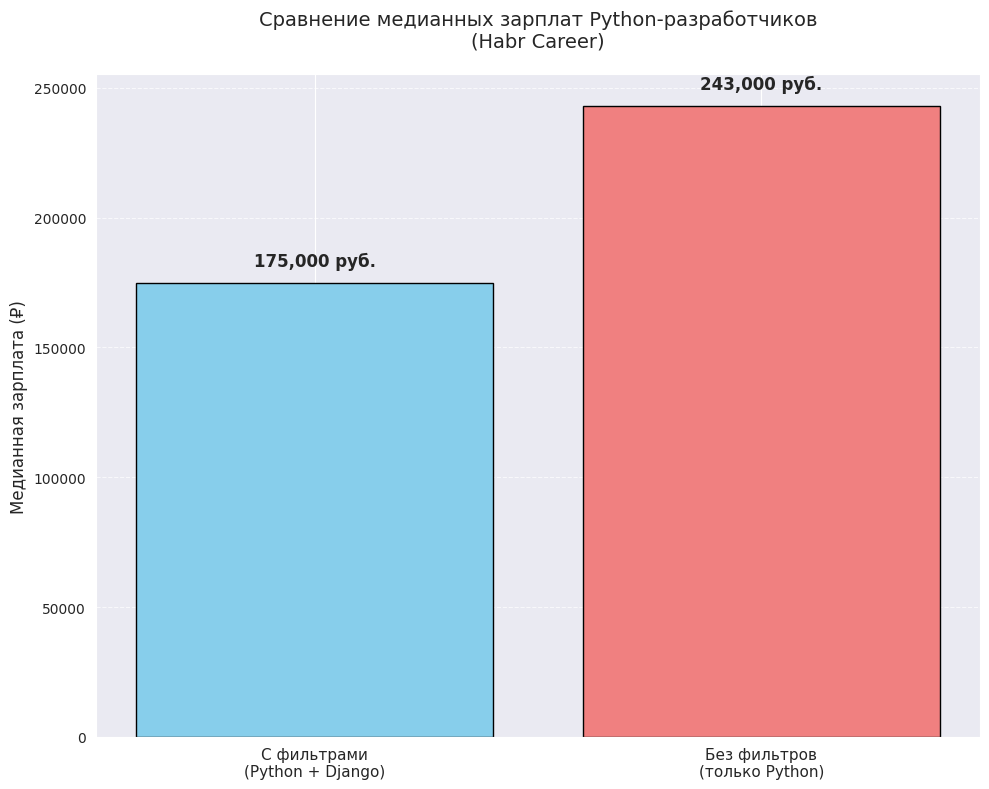

In [22]:
plt.rcParams['font.family'] = 'DejaVu Sans'
labels = ['С фильтрами\n(Python + Django)', 'Без фильтров\n(только Python)']
medians = [med_filtered, med_full]

plt.figure(figsize=(10, 8))
bars = plt.bar(labels, medians, color=['skyblue', 'lightcoral'], edgecolor='black')

for bar, median in zip(bars, medians):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
             f'{int(median):,} руб.', ha='center', va='bottom', fontsize=12, fontweight='bold')  # ← замена ₽ → "руб."

plt.title('Сравнение медианных зарплат Python-разработчиков\n(Habr Career)', fontsize=14, pad=20)
plt.ylabel('Медианная зарплата (₽)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Вывод


На основе анализа 226 вакансий с навыком `Python` и 16 вакансий с фильтрами `Python + Django`, можно сделать следующие выводы:

Медианные зарплаты и их разница:
- **Медианная зарплата (Python + Django):** **175000 ₽**
- **Медианная зарплата (все Python-вакансии):** **243000 ₽**
- **Разница:** Зарплаты с фильтром `Django` **ниже на 28,0%**

Несмотря на то, что Django — это популярный и востребованный фреймворк, вакансии, где он указан как обязательное требование, **не демонстрируют более высокую оплату труда** по сравнению с общим рынком Python-разработчиков.

Это может быть связано с такими факторами, как:
- **Уровень позиции:** Вакансии с `Django` могут чаще быть junior/middle уровня, в то время как общая выборка включает и senior-позиции.
- **Тип проекта:** Вакансии с Django часто связаны с веб-разработкой, которая может иметь более низкий ценовой порог, чем backend/ML/DevOps-роли, которые также попадают в выборку "все Python".
- **География и компания:** Возможно, компании, требующие Django, чаще находятся в регионах или имеют меньший бюджет.

Анализ дополнительной статистики:

Доля вакансий с указанием зарплаты:
  - С фильтрами (`Python + Django`): **56,2%** (9 из 16)
  - Без фильтров (`только Python`): **19,0%** (43 из 226)

Это говорит о том, что **вакансии с фильтром `Django` чаще указывают зарплату**, что может быть связано с их большей прозрачностью или целевой аудиторией.

